# Potato,Pepper and Tomato Disease Classification

# 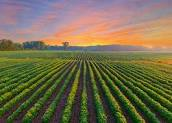

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Set all the Constants**

In [22]:
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS=15
EPOCHS=25

**Import data into tensorflow dataset object**
We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/plant-village/PlantVillage/",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


Printing the Class names

In [4]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(64, 256, 256, 3)
[ 9 12 14  6  3  0 12  5  3 11 14  8  2 10  3 10  5 12  0  1  5 11  2  2
  1  7  5 12  9 14 11  8 10 12 10 12 12 13  8  5 10  2 12  1 12 12  5  8
  9  9 11  8 10  0 12  8  3  3  2  1  5  3  9  1]


**Visualize some of the images from our dataset**

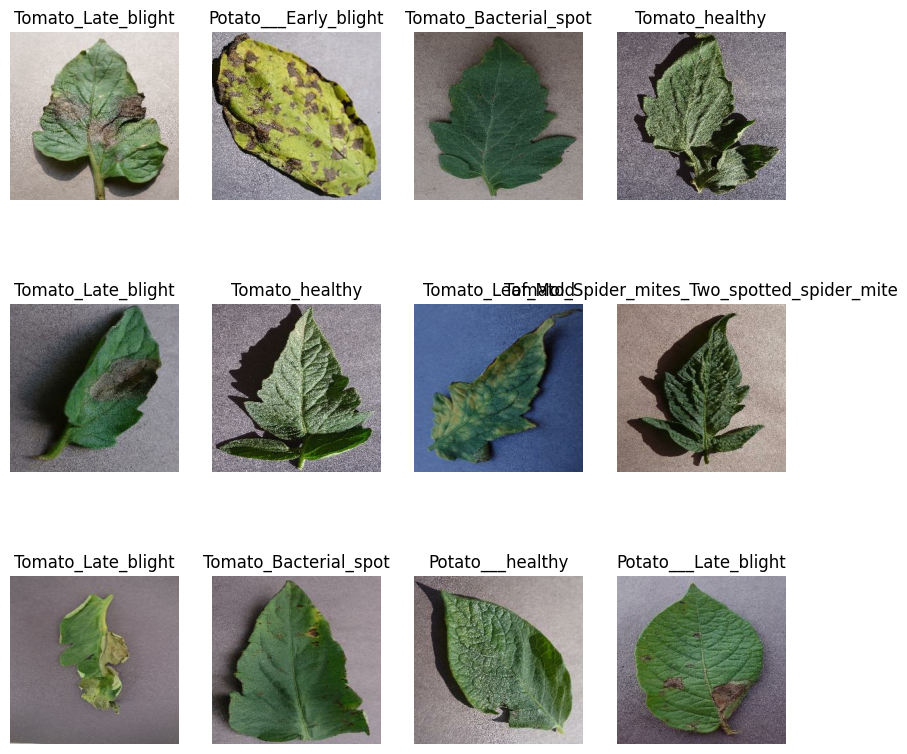

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Data Pre-Processing

**Function to Split Dataset**
Dataset should be bifurcated into 3 subsets, namely:

1) Training: Dataset to be used while training

2) Validation: Dataset to be tested against while training

3) Test: Dataset to be tested against after we trained a model

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

258

In [10]:
len(val_ds)

32

In [11]:
len(test_ds)

33

**Cache, Shuffle, and Prefetch the Dataset**

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

**Creating a Layer for Resizing and Normalization**

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 128). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.


In [13]:
# The numpy array we saw was between 0 to 255 , so now we will divide it by 255 hence we 
# can get a number between 0 and 1 
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

**Data Augmentation**

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [14]:
# Data Augmentation 
# If the image given to model while predicting is filpped then this will help the model to 
# fit the image in the model in it's actual look 
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

**Applying Data Augmentation to Train Dataset**

In [11]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [15]:
def create_model():
    
    input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
    n_classes = 15

    model = models.Sequential([
        resize_and_rescale,
        layers.Conv2D(32, (3,3),padding="same", activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64,  (3,3),padding="same", activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3,3), padding="same",activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding="same",activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding="same",activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3),padding="same",activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3),padding="same",activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64,activation='relu'),
        layers.Dense(n_classes,activation='softmax'),
    ])
    
    
    return model

In [16]:
output_dir = '/kaggle/working/'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define the file path for saving the weights
file_path = os.path.join(output_dir, 'model_weights_{epoch:02d}.h5')

cp_callback = tf.keras.callbacks.ModelCheckpoint(
        file_path,
        save_weights_only=True, 
        verbose = 1,
)


In [17]:
model = create_model()
model.build(input_shape=(64,256,256,3))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 256, 256, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (64, 128, 128, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 128, 128, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 64, 64, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (64, 64, 64, 64)         

# Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [24]:
# from tensorflow.keras.callbacks import LearningRateScheduler
# # Define the learning rate schedule
# def learning_rate_schedule(epoch):
#     # Define your learning rate schedule here
#     # Example: decrease the learning rate by a factor of 0.1 every 10 epochs
#     if epoch < 10:
#         return 0.1
#     elif epoch < 20:
#         return 0.01
#     else:
#         return 0.001

# # Create a learning rate scheduler callback
# lr_scheduler = LearningRateScheduler(learning_rate_schedule)

In [18]:
# from tensorflow.keras.optimizers import Adam
# initial_learning_rate = 0.1
# optimizer = Adam(learning_rate=initial_learning_rate)
def model_com(): 
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

In [19]:
model_com()

In [20]:
model.load_weights('/kaggle/input/wieghts-1/model_weights.h5')

In [21]:
path = "/kaggle/input/model-save-final/Plant-Disease-detection-2.h5"
model = tf.keras.models.load_model(path)

Model is already trained weel but still training it again for 5 epoch so we can plot the graph oa val and accuracy

In [23]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,  
    callbacks = cp_callback
)

Epoch 1/25
258/258 [==============================] - ETA: 0s - loss: 0.0457 - accuracy: 0.9847
Epoch 1: saving model to /kaggle/working/model_weights_01.h5
258/258 [==============================] - 1390s 5s/step - loss: 0.0457 - accuracy: 0.9847 - val_loss: 0.0120 - val_accuracy: 0.9951
Epoch 2/25
258/258 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9935
Epoch 2: saving model to /kaggle/working/model_weights_02.h5
258/258 [==============================] - 1367s 5s/step - loss: 0.0239 - accuracy: 0.9935 - val_loss: 0.0878 - val_accuracy: 0.9736
Epoch 3/25
258/258 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.9906
Epoch 3: saving model to /kaggle/working/model_weights_03.h5
258/258 [==============================] - 1363s 5s/step - loss: 0.0299 - accuracy: 0.9906 - val_loss: 0.0396 - val_accuracy: 0.9912
Epoch 4/25
258/258 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9916
Epoch 4: saving model to /kaggle/w

In [18]:
scores = model.evaluate(test_ds)

33/33 [==============================] - 95s 2s/step - loss: 0.1577 - accuracy: 0.9616


**You can see above that we get 96% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [19]:
scores

[0.1576884686946869, 0.9616477489471436]

Scores is just a list containing loss and accuracy value

# Plotting the Accuracy and Loss Curves

In [24]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 258}

In [25]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.0456620492041111,
 0.023909766227006912,
 0.029919886961579323,
 0.028494779020547867,
 0.03268689662218094]

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

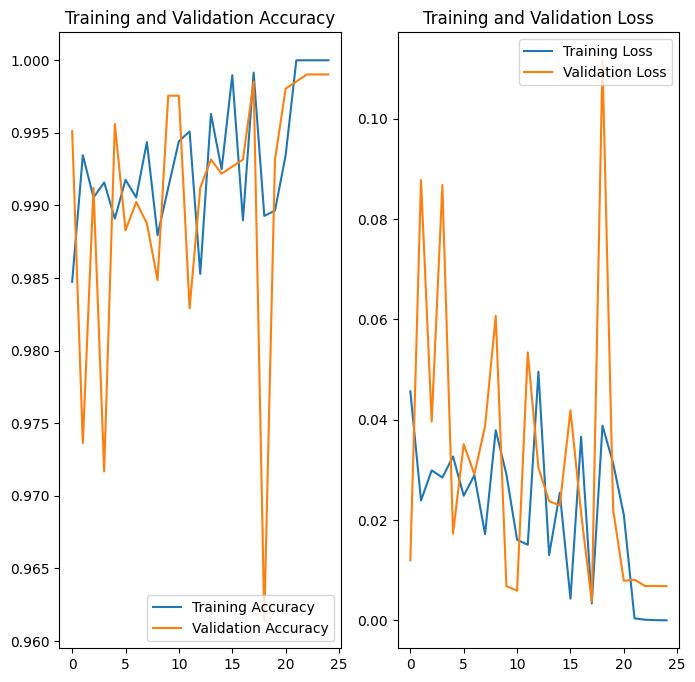

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Run prediction on a sample image**

In [ ]:

for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

**Write a function for inference**

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 45ms/step


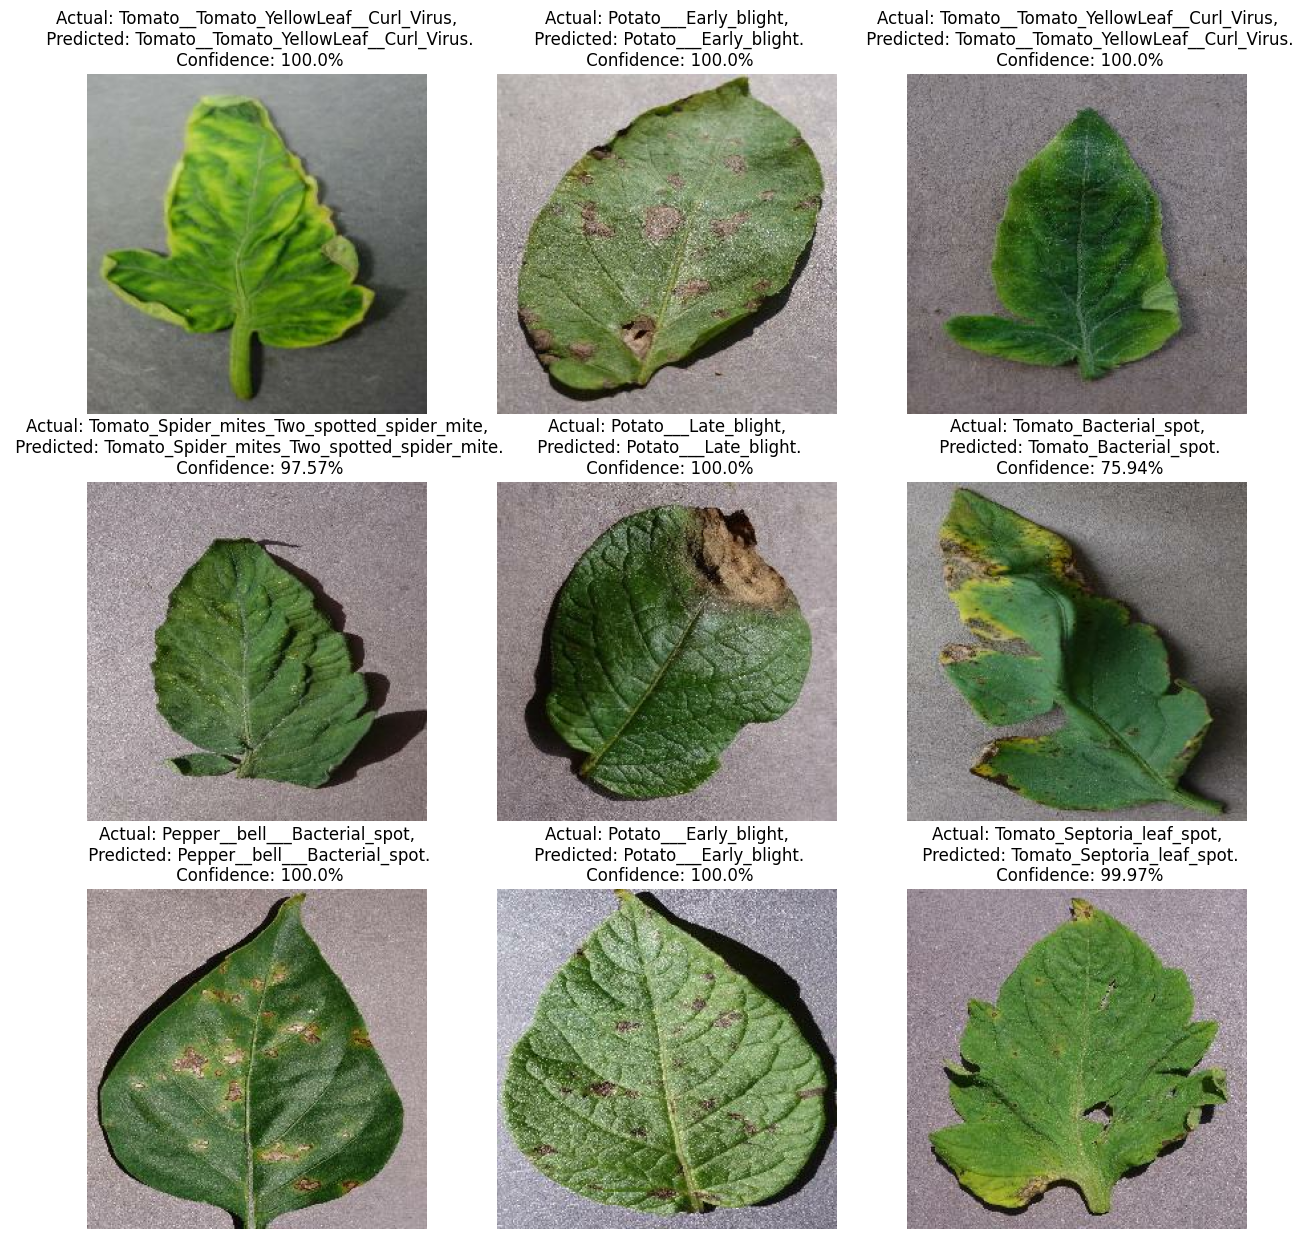

In [25]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

**Saving the Model**

We append the model to the list of models as a new version

In [30]:
model.save("/kaggle/working/Plant-Disease-detection.h5")

In [24]:
import pickle

file_path = '/kaggle/working/PlantDiseaseDetection.pkl'  # Specify the file path in the Kaggle output directory
with open(file_path, 'wb') as f:
    pickle.dump(model, f)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......conv2d_4
.........vars
............0
............1
......conv2d_5
.........vars
............0
............1
......conv2d_6
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
......max_pooling2d_3
.........vars
......max_pooling2d_4
.........vars
......max_pooling2d_5
.........vars
......max_pooling2d_6
.........vars
......sequential
.........layers
............rescaling
...............vars
............resizing
...............vars
.........vars
...metric

In [ ]:
/kaggle/working/model_weights.h5